## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, matthews_corrcoef

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, SGD
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer, Trainer, TrainingArguments,AutoTokenizer
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput


## Read Dataset

In [3]:
df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))

label_names = df['labels'].unique()
label_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int8)

Text(0, 0.5, 'Count')

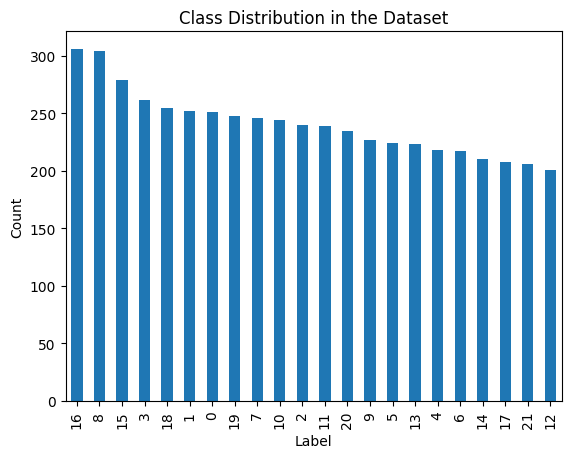

In [4]:
df['labels'].value_counts().plot(kind='bar')
plt.title("Class Distribution in the Dataset")
plt.xlabel("Label")
plt.ylabel("Count")

# Data Preprocessing
## Train Test Split

In [5]:
def split_df(X, y):    

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

    fig, axes = plt.subplots(figsize=(12,4),nrows=1, ncols=2)

    ax1=axes[0]
    y_train.value_counts().plot(ax= ax1, kind='bar')
    ax1.set_title("Class Distribution in the Train Set")
    ax1.set_xlabel("Label")
    ax1.set_ylabel("Count")


    ax2=axes[1]
    y_val.value_counts().plot(ax=ax2, kind='bar')
    ax2.set_title("Class Distribution in the Test Set")
    ax2.set_xlabel("Label")
    ax2.set_ylabel("Count")
    plt.show()
    
    return X_train, X_val, y_train, y_val

## Tokenization

In [6]:
def tokenize(model_name):
    try:
        tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
    except:
        tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
    return tokenizer

## Encode datasets

In [7]:
def encode(docs, tokenizer):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

## Process datasets

In [8]:
def preprocess_dataset(model_name, X, y, batch_size):
    # initialize tokenizer
    tokenizer = tokenize(model_name)
    
    # encode dataset with the tokenizer
    train_input_ids, train_att_masks = encode(X['text'].values.tolist(), tokenizer)

    
    # convert the labels into tensor
    train_y = torch.LongTensor(y.values.tolist())

    
    # convert the encoded dataset into dataloaders
    train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    
    return train_dataloader

# Transformer Models
## Model Creation

In [9]:
best_params_dict_path = 'best_params.text'
if os.path.exists(best_params_dict_path):
    best_prams = json.load(best_params_dict_path)
else:
    best_prams = dict.fromkeys(['best_acc', 'model', 'optimizer', 'epochs',
                            'batch_size', 'learning_rate'], 0.0)


class CustomModel(nn.Module):
    def __init__(self, checkpoint, num_labels): 
        super(CustomModel,self).__init__() 
        self.num_labels = num_labels 

        #Load Model with given checkpoint and extract its body
        self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
        self.dropout = nn.Dropout(0.1) 
        self.classifier = nn.Linear(768,num_labels) # set sequence length

    def forward(self, input_ids=None, attention_mask=None,labels=None):
        #Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        #Add custom layers
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

        logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses

        loss = None
        if labels is not None:
          # set class weights here  
#           device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#           class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device) # set weights here
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

## Model Trainer
<span style='color:red'>P1<span>

In [10]:
def trainer(model, batch_size, optimizer, epochs, train_dataloader, valid_dataloader, val_steps):

    steps = 0
    train_acc_per_epoch = []
    train_loss_per_epoch = []
    val_acc_per_epoch = []
    val_loss_per_epoch = []
    
    # Set the seed for reproducibility
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                 num_warmup_steps=0,
                num_training_steps=len(train_dataloader)*epochs )

    
    train_loss = 0
    train_total_correct = 0
    train_total_examples = 0
    
    for epoch_num in range(epochs):
        print('Epoch: ', epoch_num + 1)
        '''
        Training
        '''
        model.train()

        for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            train_loss += loss.item()

            model.zero_grad()
            loss.backward()
            del loss

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            # update accuracy
            _, predicted = torch.max(output.logits, dim=1)
            train_total_correct += (predicted == labels).sum().item()
            train_total_examples += labels.size(0)            
            steps += 1
            
            '''
            Validation
            '''

            if steps >= val_steps:
                
                model.eval()
                val_total_correct = 0
                val_total_examples = 0
                valid_loss = 0
                valid_pred = []
                valid_label = []
                with torch.no_grad():
                    for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
                        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
                        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

                        loss = output.loss
                        valid_loss += loss.item()

                        valid_label.append(labels.cpu().detach().numpy())
                        valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

                        # update accuracy
                        _, predicted = torch.max(output.logits, dim=1)
                        val_total_correct += (predicted == labels).sum().item()
                        val_total_examples += labels.size(0)
                
                val_acc_per_epoch.append(val_total_correct / val_total_examples)
                val_loss_per_epoch.append(valid_loss / steps)
                
                valid_label = np.concatenate(valid_label)
                valid_pred = np.concatenate(valid_pred)
                
                print("{0}/{1} val accuracy: {2} ".format(steps, math.ceil(len(X_val) / batch_size), val_total_correct / val_total_examples))
                print("{0}/{1} val loss: {2} ".format(steps, math.ceil(len(X_val) / batch_size), valid_loss / steps))
                
                
                train_acc_per_epoch.append(train_total_correct / train_total_examples)
                train_loss_per_epoch.append(train_loss / steps)  

                print("{0}/{1} train accuracy: {2} ".format(steps, math.ceil(len(X_train) / batch_size), train_total_correct / train_total_examples))
                print("{0}/{1} train loss: {2} ".format(steps, math.ceil(len(X_train) / batch_size), train_loss / steps + 1))
                
                steps = 0
                train_loss = 0
                train_total_correct = 0
                train_total_examples = 0
    return model, train_acc_per_epoch, train_loss_per_epoch, val_acc_per_epoch, val_loss_per_epoch, valid_label, valid_pred

## Evaluation and Plotting

In [11]:
def plot_acc(epochs, train_acc_per_epoch, val_acc_per_epoch, model_name="Initial"):
    epochs_list = range(1, len(train_acc_per_epoch) +1 )
    fig, ax = plt.subplots()
    ax.plot(epochs_list,train_acc_per_epoch,label ='training accuracy')
    ax.plot(epochs_list,val_acc_per_epoch,label ='validation accuracy')
    ax.set_title('Training and Validation Accuracy of {} model'.format(model_name))
    ax.set_xlabel('Steps')
    ax.set_ylabel('Accuracy')
    ax.legend()
    img_url = 'figures/accuracy-train-' + model_name + '.png' 
    plt.savefig(img_url)
    plt.show()
    
def plot_loss(epochs, train_loss_per_epoch, val_loss_per_epoch, model_name="Initial"):
    epochs_list = range(1, len(train_loss_per_epoch) +1 )
    fig, ax = plt.subplots()
    ax.plot(epochs_list,train_loss_per_epoch,label ='train loss')
    ax.plot(epochs_list, val_loss_per_epoch, label = 'validation loss' )
    ax.set_title('Training and Validation Loss of {} model'.format(model_name))
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.legend()
    img_url = 'figures/loss-train-' + model_name + '.png' 
    plt.savefig(img_url)
    plt.show()

In [12]:
def calculate_classification_reprot(label_names, val_label, valid_pred, model_name="Initial"):
    label_names_str = [str(x) for x in label_names]
    print('classifiation report of {} model'.format(model_name))
    print(classification_report(valid_pred, val_label, target_names=label_names_str))

In [13]:
def plot_confusion_matrix(y_preds, y_true, label_names, training=False, model_name="Initial"):
    label_names_str = [str(x) for x in label_names]
    cm = confusion_matrix(y_true, y_preds, normalize=None)
    
    index= 0
    data = []
    for row in cm:
        label = label_names[index]
        total_correct = row[index]
        total_count = row.sum()
        data.append([label, total_correct, total_count])
        index += 1
    
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ['Label', 'Correct_preds', 'Total_preds'])
    print(df)

In [14]:
def get_evaluation_results(y_test_set, predictions):
    #store results of model
    acc = accuracy_score(y_test_set, predictions)
    precision = precision_score(y_test_set, predictions,average='macro')
    recall = recall_score(y_test_set, predictions,average='macro')
    f1 = f1_score(y_test_set, predictions,average='macro')
    mcc = matthews_corrcoef(y_test_set, predictions)
    
    results = [round(acc, 4), round(precision, 4), round(recall, 4), round(f1, 4), round(mcc, 4)]
    return results

## Training

In [15]:
def training(models, optimizers, configs, dataset):
    epochs = configs['epochs']
    batch_size = configs['batch_size']
    learning_rate = configs['learning_rate']
    val_steps = configs['val_steps']
    
    X_train, y_train, X_val, y_val = dataset.values() 
    
    # dic form store results of all models
    collect_train_results_of_all_model= {
        'Metrics':['accuracy','precision','recall','f1-score', 'MCC']
    }
    
    for model_name in models:

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        train_dataloader = preprocess_dataset(model_name, X_train, y_train, configs['batch_size'])
        valid_dataloader = preprocess_dataset(model_name, X_val, y_val, configs['batch_size'])


        for optimizer_name in optimizers:
            op = str(optimizer_name).split('.')[-1].split("'")[0]
            model_name_variant = str(model_name).replace('/', '-') + '-' + op
            model_url = 'models/' + model_name_variant + '.pth'
            if os.path.exists(model_url):
                continue

            print("===========================================")
            print("Start Training of {}".format(model_name_variant))
            print("===========================================")

            model = CustomModel(checkpoint=model_name, num_labels=len(label_names)).to(device)
            optimizer = optimizer_name(model.parameters(), lr=learning_rate)
            model, train_acc_per_epoch, train_loss_per_epoch, val_acc_per_epoch, val_loss_per_epoch, valid_label, valid_pred = trainer(model, batch_size, optimizer, epochs, train_dataloader, valid_dataloader, val_steps)
            
            
            val_total_correct = (valid_label == valid_pred).sum().item()
            val_acc =  val_total_correct/len(valid_label)
            print(val_acc)
            
            plot_acc(epochs, train_acc_per_epoch, val_acc_per_epoch, model_name_variant)
            plot_loss(epochs, train_loss_per_epoch, val_loss_per_epoch, model_name_variant)
#             calculate_classification_reprot(label_names, valid_label, valid_pred, model_name_variant)
            plot_confusion_matrix(valid_pred, valid_label, label_names, True, model_name_variant)
            collect_train_results_of_all_model[model_name_variant] = get_evaluation_results(valid_label, valid_pred)
            print("\n\n")
            
#             torch.save(model.state_dict(), model_url)
            if val_acc > best_prams['best_acc']:
                best_prams['model'] = str(model_name)
                best_prams['best_acc'] = val_acc
                best_prams['optimizer'] = op
                best_prams['epochs'] = epochs
                best_prams['batch_size'] = batch_size
                best_prams['learning_rate'] = learning_rate
                
                with open(best_params_dict_path, "w") as fp:
                    json.dump(best_prams, fp)  # encode dict into JSON
                torch.save(model.state_dict(), "models/best-transformer-model.pth")

                
                
            
    metrics_data_frame = pd.DataFrame.from_dict(collect_train_results_of_all_model, orient='index')
    print(tabulate(metrics_data_frame)) # convert results in to table

## Configurations and Settings
<span style='color:red'>P2<span>

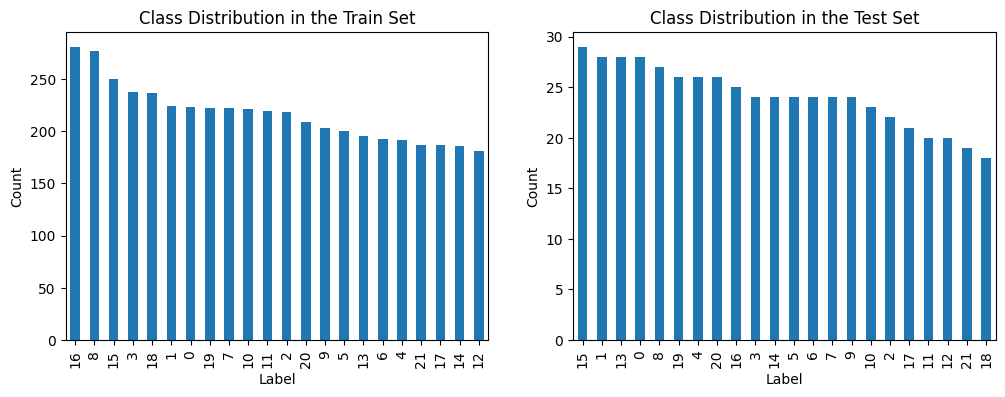

Start Training of Bert-base-german-cased-Adam


Some weights of the model checkpoint at Bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.3622641509433962 
100/34 val loss: 0.9185748124122619 
100/298 train accuracy: 0.110625 
100/298 train loss: 4.0093951773643495 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.5094339622641509 
100/34 val loss: 0.7068174886703491 
100/298 train accuracy: 0.409375 
100/298 train loss: 3.447478028535843 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.5735849056603773 
100/34 val loss: 0.5995184242725372 
100/298 train accuracy: 0.5153412648716343 
100/298 train loss: 2.9667139768600466 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6 
100/34 val loss: 0.5537709772586823 
100/298 train accuracy: 0.60625 
100/298 train loss: 2.653320316672325 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6094339622641509 
100/34 val loss: 0.5278163158893585 
100/298 train accuracy: 0.625 
100/298 train loss: 2.6384943997859955 
0.6094339622641509


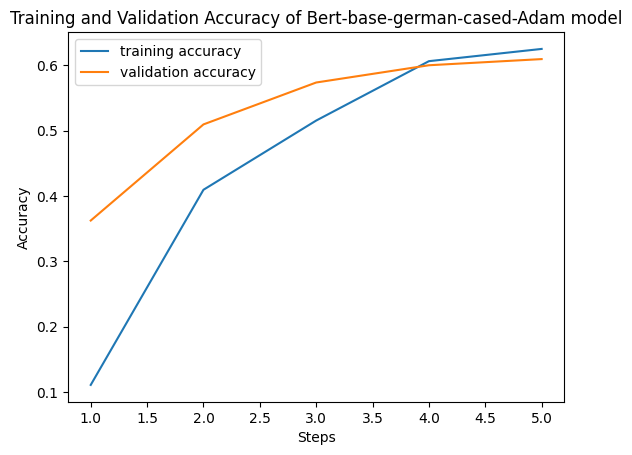

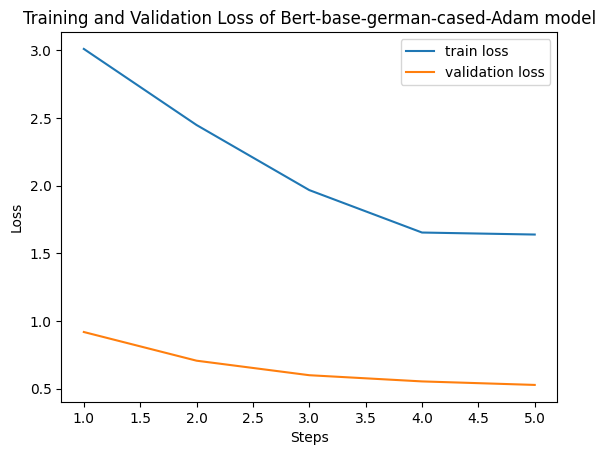

    Label  Correct_preds  Total_preds
0       0             25           28
1       1             28           28
2       2             18           22
3       3             18           24
4       4             25           26
5       5             22           24
6       6              5           24
7       7              8           24
8       8             24           27
9       9              9           24
10     10             20           23
11     11              7           20
12     12              2           20
13     13              0           28
14     14             19           24
15     15              8           29
16     16             25           25
17     17             20           21
18     18              5           18
19     19             10           26
20     20             21           26
21     21              4           19



Start Training of Bert-base-german-cased-SGD


Some weights of the model checkpoint at Bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.02830188679245283 
100/34 val loss: 1.0670966935157775 
100/298 train accuracy: 0.049375 
100/298 train loss: 4.1690444040298456 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.02830188679245283 
100/34 val loss: 1.0692667865753174 
100/298 train accuracy: 0.04 
100/298 train loss: 4.1488910579681395 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.02830188679245283 
100/34 val loss: 1.0712498259544372 
100/298 train accuracy: 0.026925485284909206 
100/298 train loss: 4.167247133255005 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.02830188679245283 
100/34 val loss: 1.0710691690444947 
100/298 train accuracy: 0.034375 
100/298 train loss: 4.155295281410217 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.02830188679245283 
100/34 val loss: 1.0699501514434815 
100/298 train accuracy: 0.038125 
100/298 train loss: 4.168040370941162 
0.02830188679245283


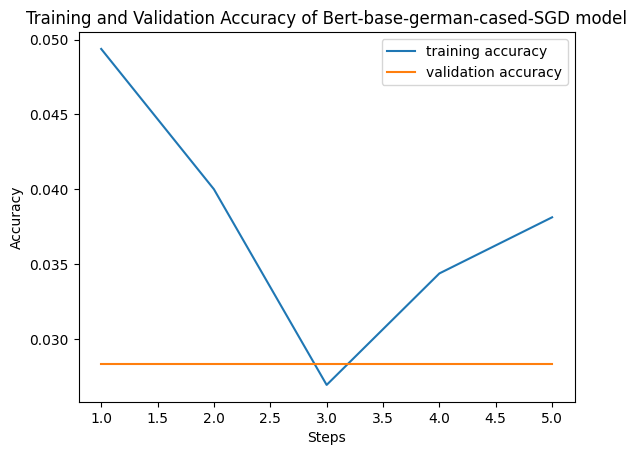

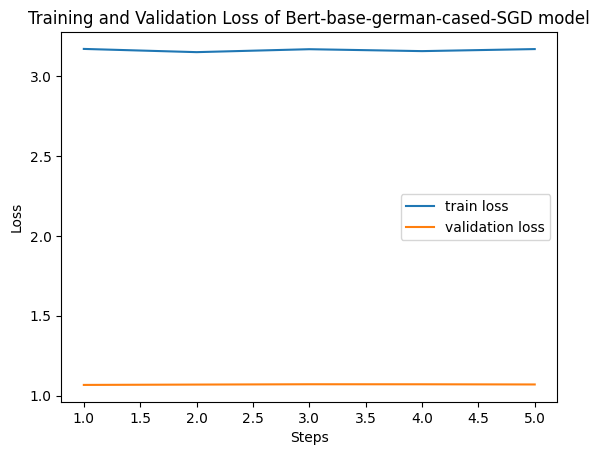

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              0           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              1           27
9       9              0           24
10     10              1           23
11     11              0           20
12     12             10           20
13     13              0           28
14     14              1           24
15     15              0           29
16     16              0           25
17     17              1           21
18     18              0           18
19     19              0           26
20     20              1           26
21     21              0           19



Start Training of Dbmdz-bert-base-german-uncased-Adam


Some weights of the model checkpoint at Dbmdz/bert-base-german-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.30943396226415093 
100/34 val loss: 0.9564770555496216 
100/298 train accuracy: 0.100625 
100/298 train loss: 4.062481393814087 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.4320754716981132 
100/34 val loss: 0.8007278800010681 
100/298 train accuracy: 0.380625 
100/298 train loss: 3.617404271364212 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.5245283018867924 
100/34 val loss: 0.6788434028625489 
100/298 train accuracy: 0.482780212899186 
100/298 train loss: 3.1808578324317933 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.590566037735849 
100/34 val loss: 0.6067748010158539 
100/298 train accuracy: 0.56375 
100/298 train loss: 2.858961468935013 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.6113207547169811 
100/34 val loss: 0.5733305060863495 
100/298 train accuracy: 0.603125 
100/298 train loss: 2.767341063022614 
0.6113207547169811


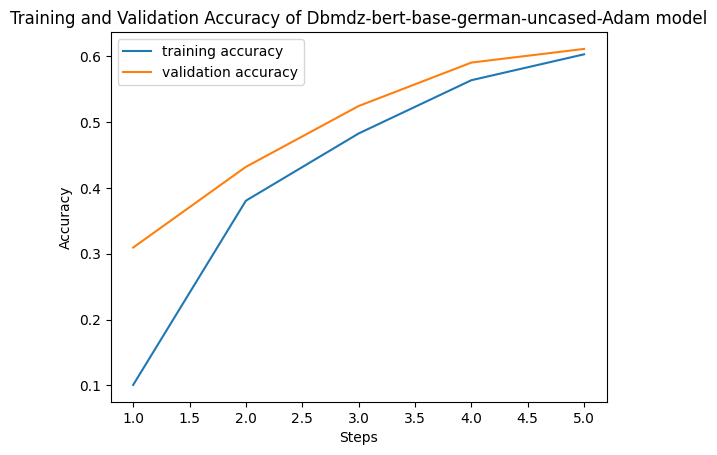

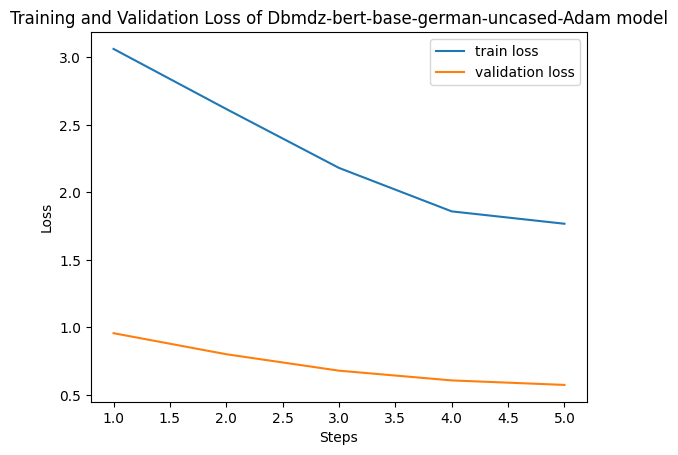

    Label  Correct_preds  Total_preds
0       0             26           28
1       1             28           28
2       2             19           22
3       3             18           24
4       4             25           26
5       5             24           24
6       6             17           24
7       7              6           24
8       8             23           27
9       9              0           24
10     10             18           23
11     11              8           20
12     12              3           20
13     13              4           28
14     14              9           24
15     15             14           29
16     16             25           25
17     17             20           21
18     18              4           18
19     19              6           26
20     20             24           26
21     21              3           19



Start Training of Dbmdz-bert-base-german-uncased-SGD


Some weights of the model checkpoint at Dbmdz/bert-base-german-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:  1


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.020754716981132074 
100/34 val loss: 1.109862244129181 
100/298 train accuracy: 0.035 
100/298 train loss: 4.247979629039764 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.020754716981132074 
100/34 val loss: 1.1051161789894104 
100/298 train accuracy: 0.024375 
100/298 train loss: 4.244009430408478 
Epoch:  2


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.020754716981132074 
100/34 val loss: 1.1105765414237976 
100/298 train accuracy: 0.028804007514088917 
100/298 train loss: 4.247854719161987 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.020754716981132074 
100/34 val loss: 1.1060111260414123 
100/298 train accuracy: 0.024375 
100/298 train loss: 4.251526234149933 


Validation:   0%|          | 0/34 [00:00<?, ?it/s]

100/34 val accuracy: 0.020754716981132074 
100/34 val loss: 1.1111630201339722 
100/298 train accuracy: 0.03 
100/298 train loss: 4.241284351348877 
0.020754716981132074


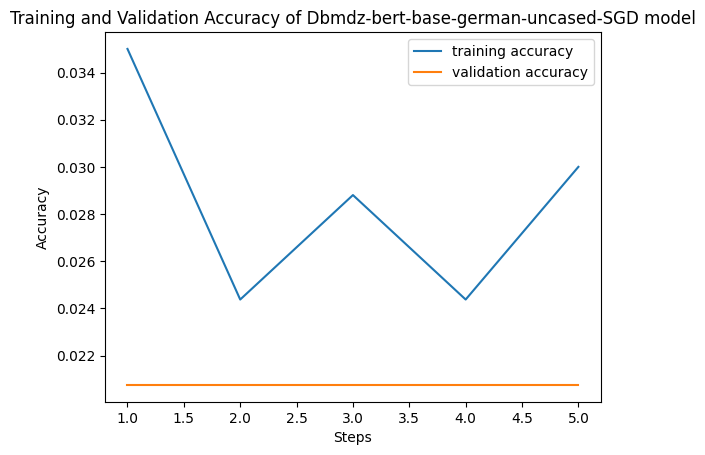

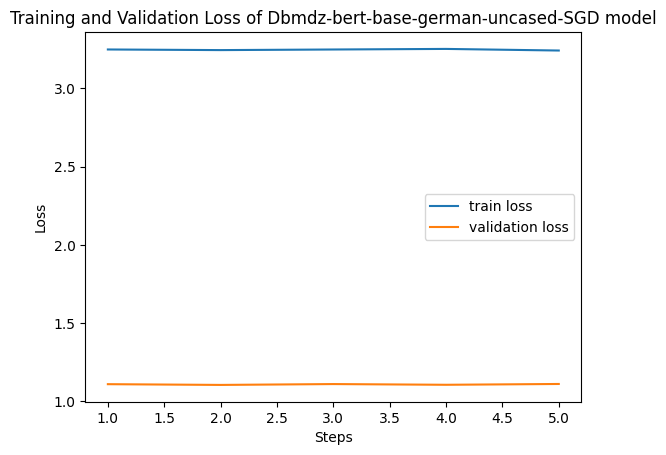

    Label  Correct_preds  Total_preds
0       0              0           28
1       1              0           28
2       2              1           22
3       3              0           24
4       4              0           26
5       5              0           24
6       6              0           24
7       7              0           24
8       8              0           27
9       9              0           24
10     10              2           23
11     11              0           20
12     12              0           20
13     13              0           28
14     14              0           24
15     15              0           29
16     16              0           25
17     17              0           21
18     18              0           18
19     19              0           26
20     20              8           26
21     21              0           19



-----------------------------------  --------  ---------  ------  --------  -------
Metrics                              ac

In [16]:
df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))
label_names = df['labels'].unique()
# label_names

X = df[['text']]
y = df['labels']
X_train, X_val, y_train, y_val = split_df(X, y)

optimizers = [Adam, SGD]
configs =     {'epochs': 2, 'batch_size': 16, 'learning_rate': 2e-6, 'val_steps':100}
dataset = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

models = ['Bert-base-german-cased', 
'Dbmdz/bert-base-german-uncased',
# 'Deepset/gbert-base',
# 'Xlm-roberta-base',
# 'Uklfr/gottbert-base'
]

training(models, optimizers, configs, dataset) 

# Testing

In [17]:
def validator(model, test_dataloader):
    model.eval()
    test_label = []
    test_pred = []
    test_loss= 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for step_num, batch_data in tqdm(enumerate(test_dataloader)):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            test_loss += loss.item()
            
            test_label.append(labels.cpu().detach().numpy())
            test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
    
    test_label = np.concatenate(test_label)
    test_pred = np.concatenate(test_pred)
    
    return test_label, test_pred

In [33]:
def testing(models, optimizers, configs, dataset):
    
    batch_size = configs['batch_size']
    X_test, y_test = dataset.values() 

    #dic form store results of all models
    collect_test_results_of_all_model= {
        'Metrics':['accuracy','precision','recall','f1-score', 'MCC']
    }
    
    for model_name in models:

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        test_dataloader = preprocess_dataset(model_name, X_test, y_test, configs['batch_size'])
        
        for optimizer_name in optimizers:
            op = str(optimizer_name).split('.')[-1].split("'")[0]
            model_name_variant = str(model_name).replace('/', '-') + '-' + op
            model_url = 'models/best-transformer-model.pth'
            if os.path.exists(model_url):

                print("===========================================")
                print("Start Validating on {}".format(model_name_variant))
                print("===========================================")

                model = CustomModel(checkpoint=model_name, num_labels=len(label_names)).to(device)
                model.load_state_dict(torch.load(model_url))
                test_label, test_pred = validator(model, test_dataloader)

                calculate_classification_reprot(label_names, test_label, test_pred, model_name_variant)
                plot_confusion_matrix(test_pred, test_label, label_names, False, model_name_variant)

<span style='color:red'>P3<span>

In [34]:
# df = pickle.load(open('path of the test set.pickle', 'rb'))

X = X_val # change with df['text'] for test text
y = y_val # change with df['label'] for test labels

with open("best_params.text", "r") as fp:
    best_prams = json.load(fp)

optimizers = [Adam, AdamW, SGD]
optimizers = [best_prams['optimizer']]

dataset = {'X_test': X, 'y_test': y}
configs =     {'epochs': 30, 'batch_size':16}
models = [best_prams['model']]




testing(models, optimizers, configs, dataset)

Start Validating on Dbmdz-bert-base-german-uncased-Adam


Some weights of the model checkpoint at Dbmdz/bert-base-german-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

classifiation report of Dbmdz-bert-base-german-uncased-Adam model
              precision    recall  f1-score   support

           0       0.96      0.75      0.84        36
           1       1.00      1.00      1.00        28
           2       0.86      1.00      0.93        19
           3       0.75      0.64      0.69        28
           4       0.96      1.00      0.98        25
           5       0.96      0.92      0.94        25
           6       0.71      0.59      0.64        29
           7       0.29      0.27      0.28        26
           8       0.85      0.51      0.64        45
           9       0.00      0.00      0.00         0
          10       0.78      0.90      0.84        20
          11       0.40      0.38      0.39        21
          12       0.15      0.27      0.19        11
          13       0.14      0.24      0.18        17
          14       0.42      0.91      0.57        11
          15       0.48      0.29      0.36        49
          16   

## check mismatches

In [38]:
def unit_testing(model_name, optimizer, test_dataloader):
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    op = str(optimizer).split('.')[-1].split("'")[0]
    model_name_variant = str(model_name).replace('/', '-') + '-' + op
#     model_url = 'models/' + model_name_variant + '.pth'
    model_url = 'models/best-transformer-model.pth' 
    
    if os.path.exists(model_url):

        model = CustomModel(checkpoint=model_name, num_labels=len(label_names)).to(device)
        model.load_state_dict(torch.load(model_url))
        test_label, test_pred = validator(model, test_dataloader)

        return test_label, test_pred
    
    return "trained model doesn't exist on path!"


optimizer = Adam
model_name = best_prams['model']
test_dataloader = preprocess_dataset(model_name, X, y, configs['batch_size'])
test_label, test_pred = unit_testing(model_name, optimizer, test_dataloader)

mismatch_df = X
mismatch_df['label'] = test_label
mismatch_df['pred'] = test_pred
print(mismatch_df[mismatch_df['label']!=mismatch_df['pred']].shape)
mismatch_df[mismatch_df['label']!=mismatch_df['pred']][['text','label','pred']]
print(mismatch_df.head(10))
mismatch_df.to_csv('mismatched.csv')

Some weights of the model checkpoint at Dbmdz/bert-base-german-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

(201, 3)
                                                     text  label  pred
2806    <b>PHS-memory 8GB RAM für MSI Leopard Pro GP62...     16    16
20352   stall_46298_120x180_de<br />Abmessung: 120 cm ...     14    14
10768   <p>Das <strong>Leinwandbild »Marilyn Monroe«</...     19    19
72240   <p><b>Warnhinweis:</b></p><p><b>Achtung</b>!? ...      9    13
108298  <b>Eigenschaften für D2UL18549/1:</b> Lotus Bl...     15     7
100115  <p><span><strong>Italienische Echtleder Busine...     21    15
36150   Die verspielt verdrehte Fantasiekette ist ein ...     20    20
85233   <p><b>BROTECT Matte Displayschutzfolie, der st...      6    18
39989   Umstandshose 40-21040 Bellybutton schwarz Mark...     20    20
9991    nevuk_104513_200x200_deVerschönern Sie Ihr Hei...     12     6


## Attention Wights

In [40]:
# Load pre-trained model and tokenizer
model_name = best_prams['model']
model_url = "models/best-transformer-model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = CustomModel(checkpoint=model_name, num_labels=len(label_names)).to(device)
model.load_state_dict(torch.load(model_url))

# Encode input sentence and get attention masks
input_sentence = "This is a sample input sentence to visualize attention weights."
input_tokens = tokenizer.encode(input_sentence, add_special_tokens=True)
input_tensor = torch.tensor([input_tokens]).to(device)
attention_mask = torch.ones_like(input_tensor).to(device)

# Forward pass through the model to get attention weights
outputs = model(input_tensor, attention_mask=attention_mask)
attentions = outputs[-1]

# Iterate over each layer and head to visualize attention weights
for layer, layer_attentions in enumerate(attentions):
    print(f"Layer {layer+1}:")
    for head, head_attentions in enumerate(layer_attentions):
        print(f"Head {head+1}:")
        for token, weight in zip(input_tokens, head_attentions):
            print(f"{tokenizer.decode([token])} - {weight[0][0].item():.4f}")
        print("\n")

Some weights of the model checkpoint at Dbmdz/bert-base-german-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Layer 1:
Head 1:
[CLS] - 0.0449
this - 0.7124
is - 0.5182
a - 0.0613
sam - 0.0138
##ple - 0.7613
in - 0.1723
##put - 0.0497
sen - 0.8242
##ten - 0.1000
##ce - 0.4499
to - 0.0035


Layer 2:
Head 1:
[CLS] - 0.9877
this - 0.8141
is - 0.7277
a - 0.9497
sam - 0.1904
##ple - 0.8496
in - 0.5634
##put - 0.7609
sen - 0.6762
##ten - 0.5853
##ce - 0.2443
to - 0.1391


Layer 3:
Head 1:
[CLS] - 0.9058
this - 0.9565
is - 0.7113
a - 0.0368
sam - 0.8532
##ple - 0.9846
in - 0.8039
##put - 0.0071
sen - 0.4799
##ten - 0.7805
##ce - 0.5921
to - 0.5401


Layer 4:
Head 1:
[CLS] - 0.8313
this - 0.8191
is - 0.8988
a - 0.8821
sam - 0.9690
##ple - 0.4895
in - 0.8827
##put - 0.7943
sen - 0.3822
##ten - 0.9507
##ce - 0.7959
to - 0.9142


Layer 5:
Head 1:
[CLS] - 0.4461
this - 0.6349
is - 0.7993
a - 0.9237
sam - 0.5568
##ple - 0.7200
in - 0.4252
##put - 0.6942
sen - 0.8811
##ten - 0.7253
##ce - 0.8673
to - 0.3779


Layer 6:
Head 1:
[CLS] - 0.3860
this - 0.5995
is - 0.0456
a - 0.3563
sam - 0.1672
##ple - 0.1770
in 